In [1]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ARIMA and VAR model libaries
from scipy import stats
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Random Forest libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import norm

# Hide warning messages to read outputs easier
import warnings
warnings.filterwarnings("ignore")

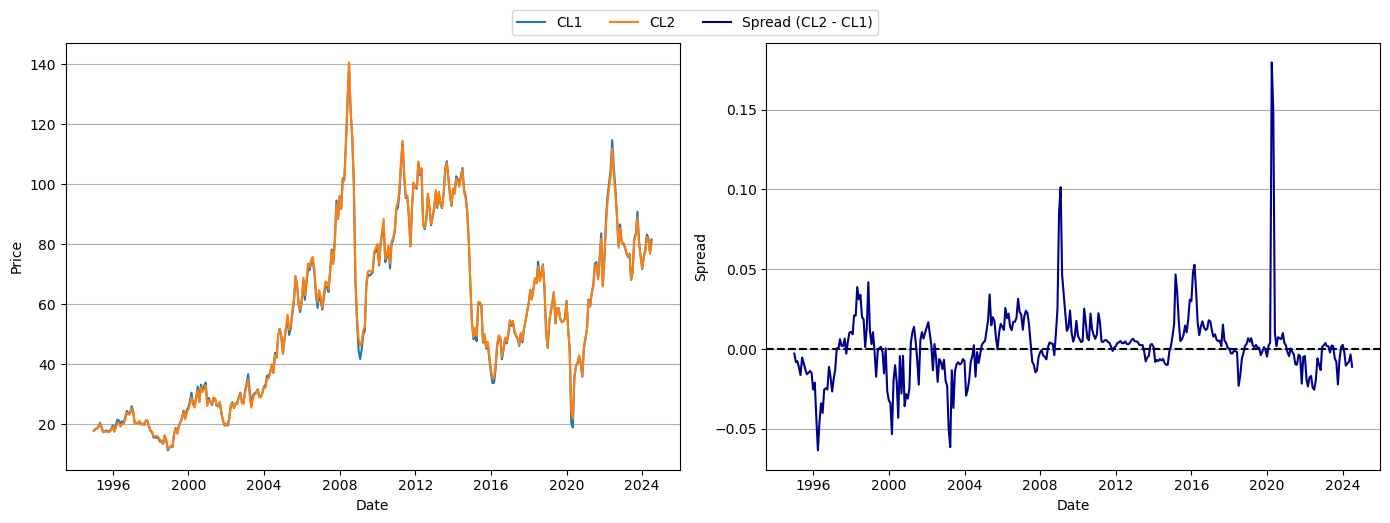

In [2]:
# Import relevant sheets from Excel file
industry_monthly_data = pd.read_excel('Oil Data.xlsx', sheet_name='Industry_M')
macro_data = pd.read_excel('Oil Data.xlsx', sheet_name='Macro_M')
stock_prices = pd.read_excel('Oil Data.xlsx', sheet_name='StockPrices_M')

# Create new column for the oil prices spread
industry_monthly_data['Spread'] = np.log(industry_monthly_data['CL2']) - np.log(industry_monthly_data['CL1'])

# Convert date columns into datetime format
industry_monthly_data['Date'] = pd.to_datetime(industry_monthly_data['Date'])
macro_data['Date'] = pd.to_datetime(macro_data['Date'])
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
last_date = industry_monthly_data['Date'].max()

# Converted date frequency into monthly
industry_monthly_data['Date'] = industry_monthly_data['Date'].dt.to_period('M').dt.to_timestamp('M')
macro_data['Date'] = macro_data['Date'].dt.to_period('M').dt.to_timestamp('M')
stock_prices['Date'] = stock_prices['Date'].dt.to_period('M').dt.to_timestamp('M')

# Merged the separate datasets into one large dataset
merged_data = industry_monthly_data.merge(macro_data, on='Date', how='inner')
merged_data = merged_data.merge(stock_prices, on='Date', how='inner')
merged_data = merged_data.sort_values('Date')

# Plot the prices and spread for visualisation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].grid(axis='y')
ax[0].plot(merged_data['Date'], merged_data['CL1'], label="CL1")
ax[0].plot(merged_data['Date'], merged_data['CL2'], label="CL2")
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')

ax[1].grid(axis='y')
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].plot(merged_data['Date'], merged_data['Spread'], color='darkblue', label='Spread (CL2 - CL1)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Spread')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

plt.tight_layout()

# Drop unneccessary columns
merged_data = merged_data.drop(columns=['CL1', 'CL2', 'Total Open Interest', 'Shell'])

In [3]:
# AdFuller test 
for i in merged_data:
    if i == "Date": # Ignore the Date column
        continue
    adfullertest = adfuller(merged_data[i].dropna())
    if adfullertest[1] > 0.05: # Difference any column if p-value > 0.05 (i.e. non stationary)
        merged_data[i] = merged_data[i].diff()
merged_data_adfuller_cleaned = merged_data.dropna()

# KPSS test
for i in merged_data:
    if i == "Date": # Ignore the Date column
        continue
    kpsstest = adfuller(merged_data[i].dropna())
    if kpsstest[1] > 0.05: # Difference any column if p-value > 0.05 (i.e. non stationary)
        merged_data[i] = merged_data[i].diff()
merged_data_kpss_cleaned = merged_data.dropna()

model_vars = ['Brent', 'CRKS321C Index', 'Baltic Dry Index',
       'Daily Production', 'Inventories', 'Rig Count', 'Commercial Long',
       'Commercial Short', 'Spread', 'CPI YOY %', '3M Yield', '10Y Yield',
       'IndustrialProduction Index', 'SPX', 'DXY returns', 'VIX',
       'Gasoline All Grades', 'Dow Jones US Oil&Gas Index']

# Fit the cleaned data to an initial VAR model to determine the information criteria values
var_data = merged_data_adfuller_cleaned[model_vars]
model = VAR(var_data)
lag_order = model.select_order()
print(f"Lag orders: AIC: {lag_order.aic}, BIC: {lag_order.bic}, HQIC: {lag_order.hqic}")
optimal_lag = max(lag_order.aic, lag_order.bic, lag_order.hqic)
print("Optimal lag:", optimal_lag)

Lag orders: AIC: 16, BIC: 1, HQIC: 1
Optimal lag: 16


In [4]:
# Granger Causality test to identify significant variables 
significant_vars = ['Spread']
for i in model_vars:
    if i != 'Spread':
        gctest = grangercausalitytests(var_data[['Spread', i]], maxlag=optimal_lag, verbose=False)
        p_values = min(gctest[lag][0]['ssr_ftest'][1] for lag in range(1, optimal_lag))
        print(f"Variable: {i}, p-values: {p_values}")
        if p_values < 0.05:
            significant_vars.append(i)

print("Significant variables are:", significant_vars)

Variable: Brent, p-values: 0.00044824726120029575
Variable: CRKS321C Index, p-values: 0.5468943835740339
Variable: Baltic Dry Index, p-values: 0.00023947987645098938
Variable: Daily Production, p-values: 0.04716508511109964
Variable: Inventories, p-values: 0.02203867129298361
Variable: Rig Count, p-values: 0.6235040321789747
Variable: Commercial Long, p-values: 0.28165626955501877
Variable: Commercial Short, p-values: 0.28067436372980975
Variable: CPI YOY %, p-values: 0.06019321113835445
Variable: 3M Yield, p-values: 0.0003021989983726789
Variable: 10Y Yield, p-values: 0.0012389935266441257
Variable: IndustrialProduction Index, p-values: 0.0001935472137389006
Variable: SPX, p-values: 0.0070204672823988125
Variable: DXY returns, p-values: 0.4105167697932707
Variable: VIX, p-values: 0.0019561635400292695
Variable: Gasoline All Grades, p-values: 0.0008221774440284121
Variable: Dow Jones US Oil&Gas Index, p-values: 0.0009397973234128558
Significant variables are: ['Spread', 'Brent', 'Balti

Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 14, 'n_estimators': 217}
Negative MSE for each fold: [-0.00034724 -0.0001933  -0.00016249 -0.00012404 -0.00081001]
Mean Negative MSE from Cross-Validation: -0.000
Mean MSE from Cross-Validation: 0.000
R-squared: 0.070
Mean Squared Error (MSE): 0.001
Root Mean Squared Error (RMSE): 0.028
Mean Absolute Error (MAE): 0.012


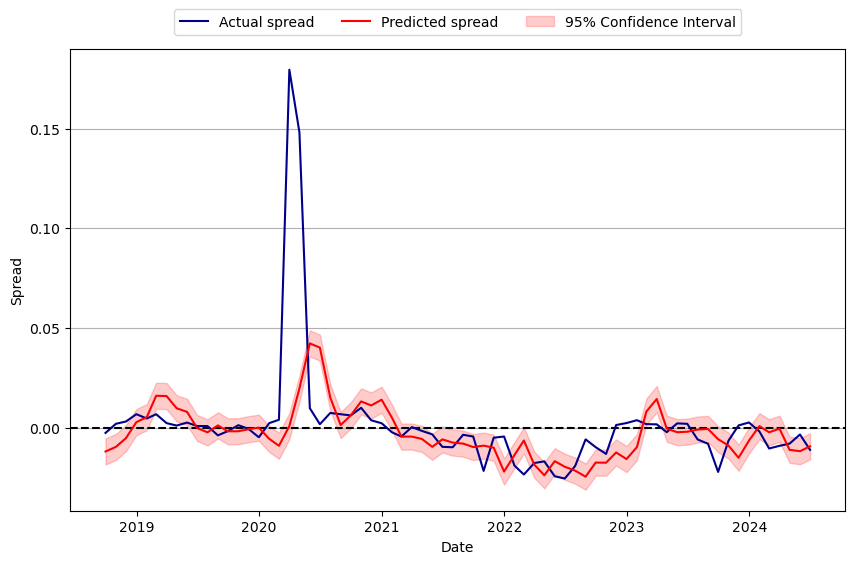

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint, norm

# Prepare data for RandomForestRegressor
random_forest_data = merged_data_adfuller_cleaned[significant_vars]
random_forest_data = random_forest_data.drop

# Create lag features
for lag in range(1, 5):  # 3 lagged features
    random_forest_data[f'Spread_lag{lag}'] = merged_data_adfuller_cleaned['Spread'].shift(lag)

# Define dependent variable y
optimal_lag = max(3, 1)  # Ensure optimal_lag is at least 1
y = merged_data_adfuller_cleaned['Spread'].iloc[optimal_lag:]

# Clean up column names
random_forest_data.columns = random_forest_data.columns.str.strip()

# Drop redundant or unavailable columns
drop_cols = ['Spread', 'Daily Production', 'Gasoline All Grades']
random_forest_data = random_forest_data.drop(columns=[col for col in drop_cols if col in random_forest_data.columns])

# Create lagged independent variable X
X = pd.concat([random_forest_data.shift(i) for i in range(1, optimal_lag + 1)], axis=1).dropna()

# Ensure y and X align in index
y = y.loc[X.index]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=60)
rf_model.fit(X_train, y_train)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=5, n_jobs=-1, random_state=60)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

# Cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Negative MSE for each fold:", cv_scores)

# Compute and display the mean MSE
mean_cv_score = np.mean(cv_scores)
print(f'Mean Negative MSE from Cross-Validation: {mean_cv_score:.3f}')
print(f'Mean MSE from Cross-Validation: {-mean_cv_score:.3f}')

# Make predictions
y_pred = rf_model.predict(X_test)

# Accuracy metrics
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared:.3f}')
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.3f}')
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

# Calculate residuals and confidence intervals
residuals = y_test - y_pred
std_error = np.std(residuals)
n = len(y_pred)
z_score = norm.ppf(0.975)
margin_of_error = z_score * (std_error / np.sqrt(n))

ci_lower = y_pred - margin_of_error
ci_upper = y_pred + margin_of_error

# Ensure dataset is sorted by date for plotting
merged_data_cleaned = merged_data_adfuller_cleaned.sort_values('Date')

# Apply exponential transformation correctly
residuals = np.exp(residuals) - 1

# Plot results
plt.figure(figsize=(10, 6))
plt.grid(axis='y') 
plt.axhline(y=0, color='black', linestyle='--')
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_test):], y_test, label='Actual spread', color='darkblue')
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_pred):], y_pred, label='Predicted spread', color='red')
plt.fill_between(
    merged_data_cleaned['Date'].iloc[-len(y_pred):], ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval'
)
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.show()


In [ ]:
# Compute daily percentage change
spread_pct_change = merged_data_adfuller_cleaned['Spread'].pct_change()

# Define a threshold for extreme movements
upper_bound = spread_pct_change.quantile(0.95)
lower_bound = spread_pct_change.quantile(0.05)

weights = np.where((spread_pct_change < lower_bound) | (spread_pct_change > upper_bound), 0.1, 1)

shock_dates = (merged_data_adfuller_cleaned['Date'].between('2008-09-01', '2009-06-01')) | \
              (merged_data_adfuller_cleaned['Date'].between('2020-03-01', '2020-12-31'))
merged_data_adfuller_cleaned['Shocks'] = np.where(shock_dates, 1, 0)

random_forest_data = merged_data_adfuller_cleaned[significant_vars + ['Shocks']] # Create random forest data
random_forest_data['Shocks'] = random_forest_data['Shocks'].astype('category')
# Shift the spread data by the optimal lag to ensure the data aligns according to the date
y = merged_data_adfuller_cleaned['Spread'][optimal_lag:]
random_forest_data.columns = random_forest_data.columns.str.strip()  # Remove leading/trailing spaces
random_forest_data = random_forest_data.drop(['Spread', 'Daily Production', 'Inventories', 'SPX', 'VIX', '10Y Yield'], axis=1)

In [ ]:
# Lag data for each lag number between 1 and the optimal lag
X = pd.concat([random_forest_data.shift(i) for i in range(1, optimal_lag+1)], axis=1).dropna()

# Split the in-sample and out-of-sample data into 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the in-sample data to the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=250, random_state=60, max_depth=20, min_samples_split=12)
rf_model.fit(X_train, y_train, sample_weight=weights[:len(y_train)])

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define a randomized parameter grid for Random Forest
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize RandomizedSearchCV with 5 iterations and parallelization
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=5, n_jobs=-1, random_state=60)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", random_search.best_params_)

from sklearn.model_selection import cross_val_score

# Perform K-fold cross-validation (5-fold here)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Print the negative mean squared errors for each fold
print("Negative MSE for each fold:", cv_scores)

# Calculate the average of the scores
mean_cv_score = np.mean(cv_scores)
print(f'Mean Negative MSE from Cross-Validation: {mean_cv_score:.3f}')

# You can convert negative MSE to positive MSE by negating the score
mean_cv_score_positive = -mean_cv_score
print(f'Mean MSE from Cross-Validation: {mean_cv_score_positive:.3f}')

# Use the out-of-sample data to predict the spread
y_pred = rf_model.predict(X_test)

# Calculate important accuracy metrics
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared:.3f}')
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.3f}')
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

# Calculate residuals (errors)
residuals = y_test - y_pred

# Estimate the standard deviation of the residuals (error)
std_error = np.std(residuals)

# Calculate confidence intervals for the predictions
n = len(y_pred)
z_score = norm.ppf(0.975)
margin_of_error = z_score * (std_error / np.sqrt(n))

# Confidence intervals
ci_lower = y_pred - margin_of_error
ci_upper = y_pred + margin_of_error

merged_data_cleaned = merged_data_adfuller_cleaned.sort_values('Date')
residuals = np.exp(residuals) - 1

plt.figure(figsize=(10, 6))
plt.grid(axis='y') 
plt.axhline(y = 0, color='black', linestyle='--')
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_test):], y_test, label='Actual spread', color='darkblue')
plt.plot(merged_data_cleaned['Date'].iloc[-len(y_pred):], y_pred, label='Predicted spread', color='red')
plt.fill_between(merged_data_cleaned['Date'].iloc[-len(y_pred):], ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Text(0.5, 1.0, 'Autocorrelation of Residuals')

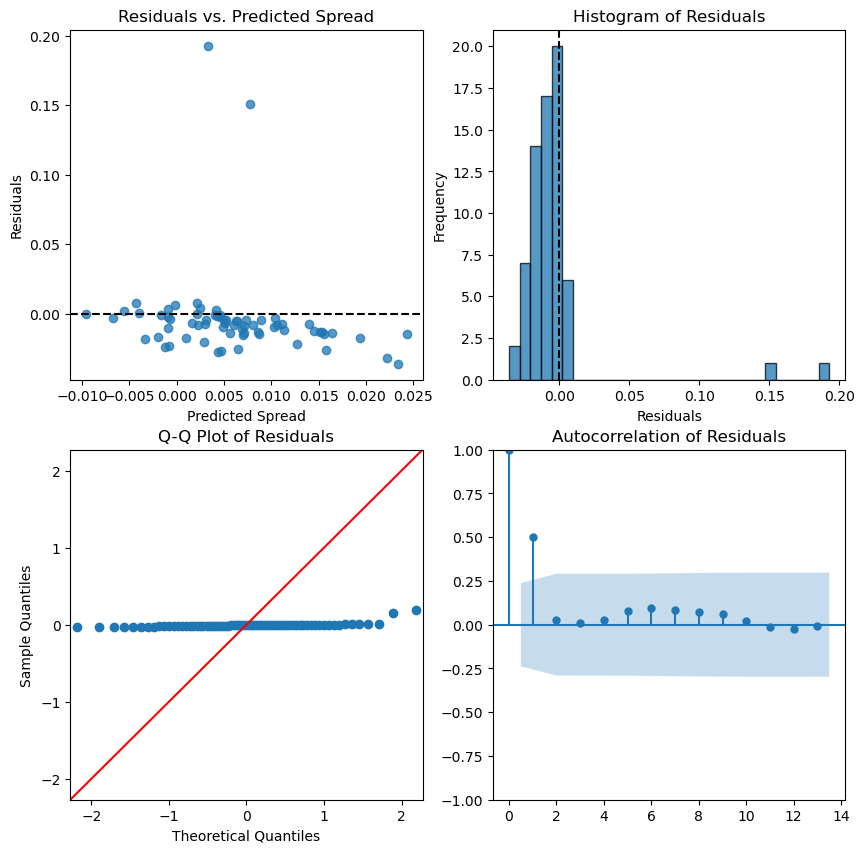

In [ ]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# 1. Residuals vs Predicted Spread
ax[0, 0].scatter(y_pred, residuals, alpha=0.75)
ax[0, 0].axhline(y=0, color='black', linestyle='--')
ax[0, 0].set_xlabel('Predicted Spread')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs. Predicted Spread')

# 2. Histogram of Residuals
ax[0, 1].hist(residuals, bins=30, alpha=0.75, edgecolor='black')
ax[0, 1].axvline(x=0, color='black', linestyle='--')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Histogram of Residuals')

# 3. Q-Q Plot of Residuals
sm.qqplot(residuals, line='45', ax=ax[1, 0])
ax[1, 0].set_title('Q-Q Plot of Residuals')

# 4. Autocorrelation of Residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=13, ax=ax[1, 1])
ax[1, 1].set_title('Autocorrelation of Residuals')

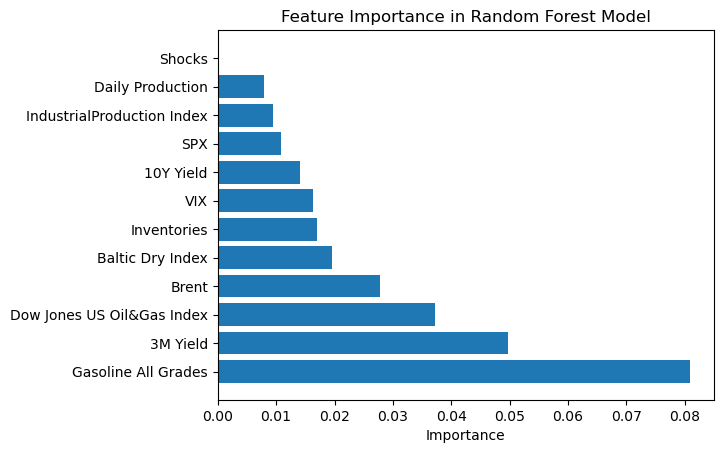

In [ ]:
# Assuming rf_model is your RandomForestRegressor and X is your feature data
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the bar chart with color gradient based on feature importance
plt.barh(importance_df['Feature'], importance_df['Importance'])

plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()


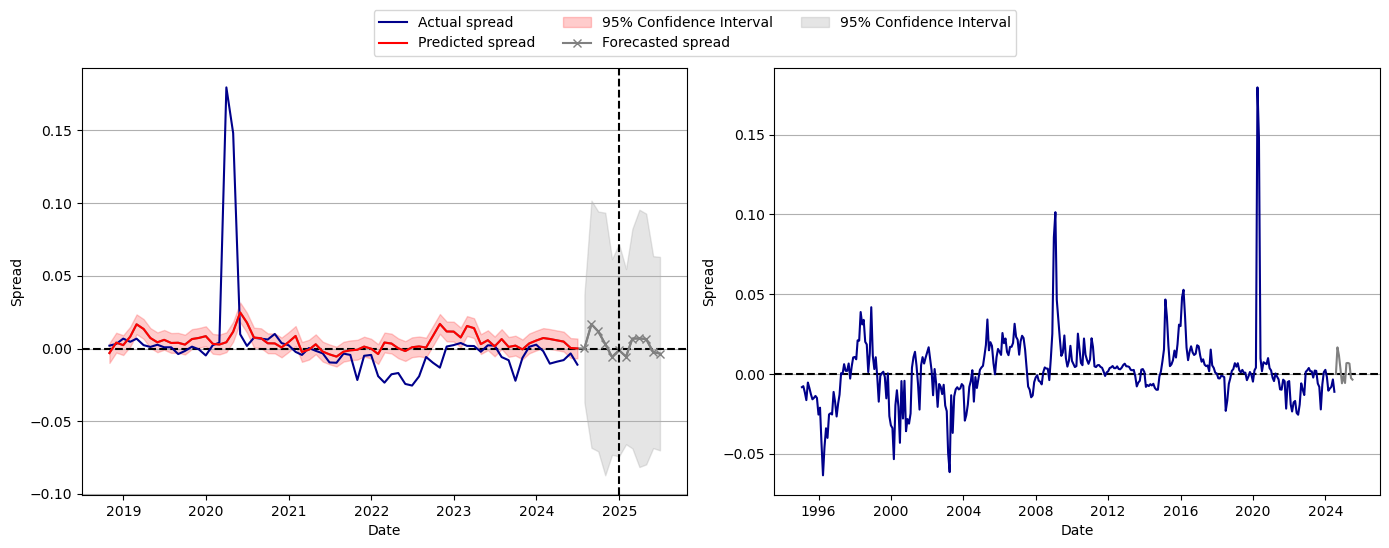

In [ ]:
future_predictions = []
forecast_std_dev = []
forecast_period = 12
last_data = X_test.iloc[-1].values.reshape(1, -1)

for _ in range(forecast_period):
    # Predict using all trees in the Random Forest
    tree_predictions = np.array([tree.predict(last_data)[0] for tree in rf_model.estimators_])
    
    # Mean prediction
    next_pred = np.mean(tree_predictions)
    future_predictions.append(next_pred)
    
    # Standard deviation of predictions
    forecast_std_dev.append(np.std(tree_predictions))
    
    # Update last_data by shifting it and appending new prediction
    last_data = np.roll(last_data, shift=-1, axis=1)
    last_data[0, -1] = next_pred

# Generate forecast dates
forecast_dates = pd.date_range(start=merged_data_cleaned['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='M')

# Convert forecasted values and standard deviation into DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted Spread': future_predictions,
    'Std Dev': forecast_std_dev
})

# Compute 95% confidence interval
z_score = norm.ppf(0.975)  # 1.96 for 95% confidence
forecast_df['Lower Bound'] = forecast_df['Predicted Spread'] - (z_score * forecast_df['Std Dev'])
forecast_df['Upper Bound'] = forecast_df['Predicted Spread'] + (z_score * forecast_df['Std Dev'])

# Combine predicted (y_pred) with forecasted values (future_predictions)
combined_predictions = np.concatenate([y_pred, future_predictions])

# Combine the dates of the predicted and forecasted data
combined_dates = pd.concat([
    merged_data_cleaned['Date'].iloc[-len(y_pred):],
    forecast_df['Date']
]).reset_index(drop=True)

# Create a combined DataFrame
combined_df = pd.DataFrame({
    'Date': combined_dates,
    'Predicted Spread': combined_predictions
}).sort_values('Date').reset_index(drop=True)

vertical_line_date = pd.to_datetime('2025-01-01')

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].grid(axis='y') 
ax[0].axhline(y=0, color='black', linestyle='--')
ax[0].plot(merged_data_cleaned['Date'].iloc[-len(y_test):], y_test, label='Actual spread', color='darkblue')
ax[0].plot(combined_dates, combined_predictions, color='grey')
ax[0].plot(combined_df['Date'].iloc[:len(y_pred)], combined_df['Predicted Spread'].iloc[:len(y_pred)], label='Predicted spread', color='red')
ax[0].fill_between(merged_data_cleaned['Date'].iloc[-len(y_pred):], ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval')
ax[0].plot(combined_df['Date'].iloc[len(y_pred):], combined_df['Predicted Spread'].iloc[len(y_pred):], label='Forecasted spread', color='grey', marker='x')
ax[0].fill_between(forecast_df['Date'], forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='grey', alpha=0.2, label='95% Confidence Interval')
ax[0].axvline(x=vertical_line_date, color='black', linestyle='--')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Spread')

ax[1].grid(axis='y') 
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].plot(merged_data_cleaned['Date'], merged_data_cleaned['Spread'], label='Actual spread', color='darkblue')
ax[1].plot(combined_df['Date'].iloc[len(y_pred):], combined_df['Predicted Spread'].iloc[len(y_pred):], label='Forecasted spread', color='grey')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Spread')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()